# Demo: Discrete-time Models for the Growth of a Population of Paramecia 

### Recommended Reading

Gerda de Vries et al., *A Course in Mathematical Biology*, SIAM, 2006. https://epubs.siam.org/doi/book/10.1137/1.9780898718256

Georgy Gause, *The Struggle for Existence*, Dover, 1971. Reprint of the 1934 edition published by The Williams \& Wilkins Co. https://store.doverpublications.com/0486838293.html

In this demo, we investigate the growth of a population of single-celled organisms based on simple laboratory data. We propose three different **discrete-time difference equation** models to describe the growth, explain how model parameters can be chosen systematically, and finally examine how well our models actually fit the data. 

The emphasis here is more on formulating the models and understanding their consequences. In particular, the mathematics underlying our parameter estimation techniques (linear and nonlinear regression) is not discussed: we treat the fitting routines as simple "black boxes". 

The discussion here is heavily based off of Chapter 1 of de Vries et al. 

## Section 1: Handling Gause's Data in Python

Georgy Gause was a Russian biologist active in the early twentieth century. He was interested in understanding the mathematical principles underlying evolution and population growth. 

Gause performed experiments on the growth of a laboratory population of *Paramecium aurelia* (https://en.wikipedia.org/wiki/Paramecium_aurelia) over twenty-six days. The paramecium population began with only a few cells, and was provided with a constant supply of nutrients. Here, we seek to create a mathematical model that fits Gause's laboratory observations of the population's growth. 

I have made Gause's data (see pp. 144-145 of *The Struggle for Existence*) available on git as a single comma-separated value (CSV) file. Missing or ill-defined values are listed as NaN (not-a-number) in the file.

Running the code below will automatically download this datafile for you and save it in a folder called "datasets" in the same folder where you are storing this Jupyter notebook. 

Additionally, following de Vries et al. p. 11, I made sure the data also included the change in density (note: there is a typo in de Vries et al. : the day 3 change should read 22, not 32). 

The following code for downloading and loading our data is (lovingly) stolen from Aurelien Geron (https://github.com/ageron/handson-ml2/blob/master/01_the_machine_learning_landscape.ipynb). You don't need to understand all the Python stuff here to get the big math bio ideas we want to focus on!

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import urllib.request


# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# add the folder "datasets" to our path... more on this below
PATH = os.path.join("datasets") 

# specify the URL where the data can be downloaded
URL = "https://github.com/ageorgemorgan/mathcircles/blob/main/gause_data.csv"

# create a function that creates a folder called 'datasets' in your current directory, downloads
# the data from my git repo, and finally loads the data as a Pandas dataframe. 
def fetch_and_load_gause_data(my_url=URL, my_path=PATH):
    # first, if the 'datasets' folder doesn't exist, make it
    if not os.path.isdir(my_path):
        os.makedirs(my_path)
    # then add the filename of the data file to your path
    csv_path = os.path.join(my_path, "gause_data.csv")
    # download the data from the url specified above and save it to the datasets folder
    # with the specified name
    urllib.request.urlretrieve(my_url, csv_path)
    # finally, use Pandas to read the data... 
    data = pd.read_csv("gause_data.csv")
    # and output the resulting Pandas dataframe
    return data 

#now just call the handy function above and presto, you have 
# an up-to-date version of the data ready to play with! 
data = fetch_and_load_gause_data()

Having loaded the data, let's take a look at it using Pandas' handy "display" capability.  

In [3]:
display(data)

,Day,Density,Change in Density
0,0,2.0,NaN
1,1,NaN,NaN
2,2,14.0,20.0
3,3,34.0,22.0
4,4,56.0,38.0
5,5,94.0,95.0
6,6,189.0,77.0
7,7,266.0,64.0
8,8,330.0,86.0
9,9,416.0,91.0


Thus, the data gives observations on density as a function of time. Note that the variable "density" here means "number of organisms per cubic centimetre". The change in density is just computed from the density itself: I could have only included density in the CSV, but chose to pre-compute the change for your convenience. If $p_{n}$ denotes the density at time $n$, then the density changes are defined by 
$$
\Delta p_{n} = p_{n+1} - p_{n}. 
$$

To bring the table to life, we plot the evolution of density over time. 

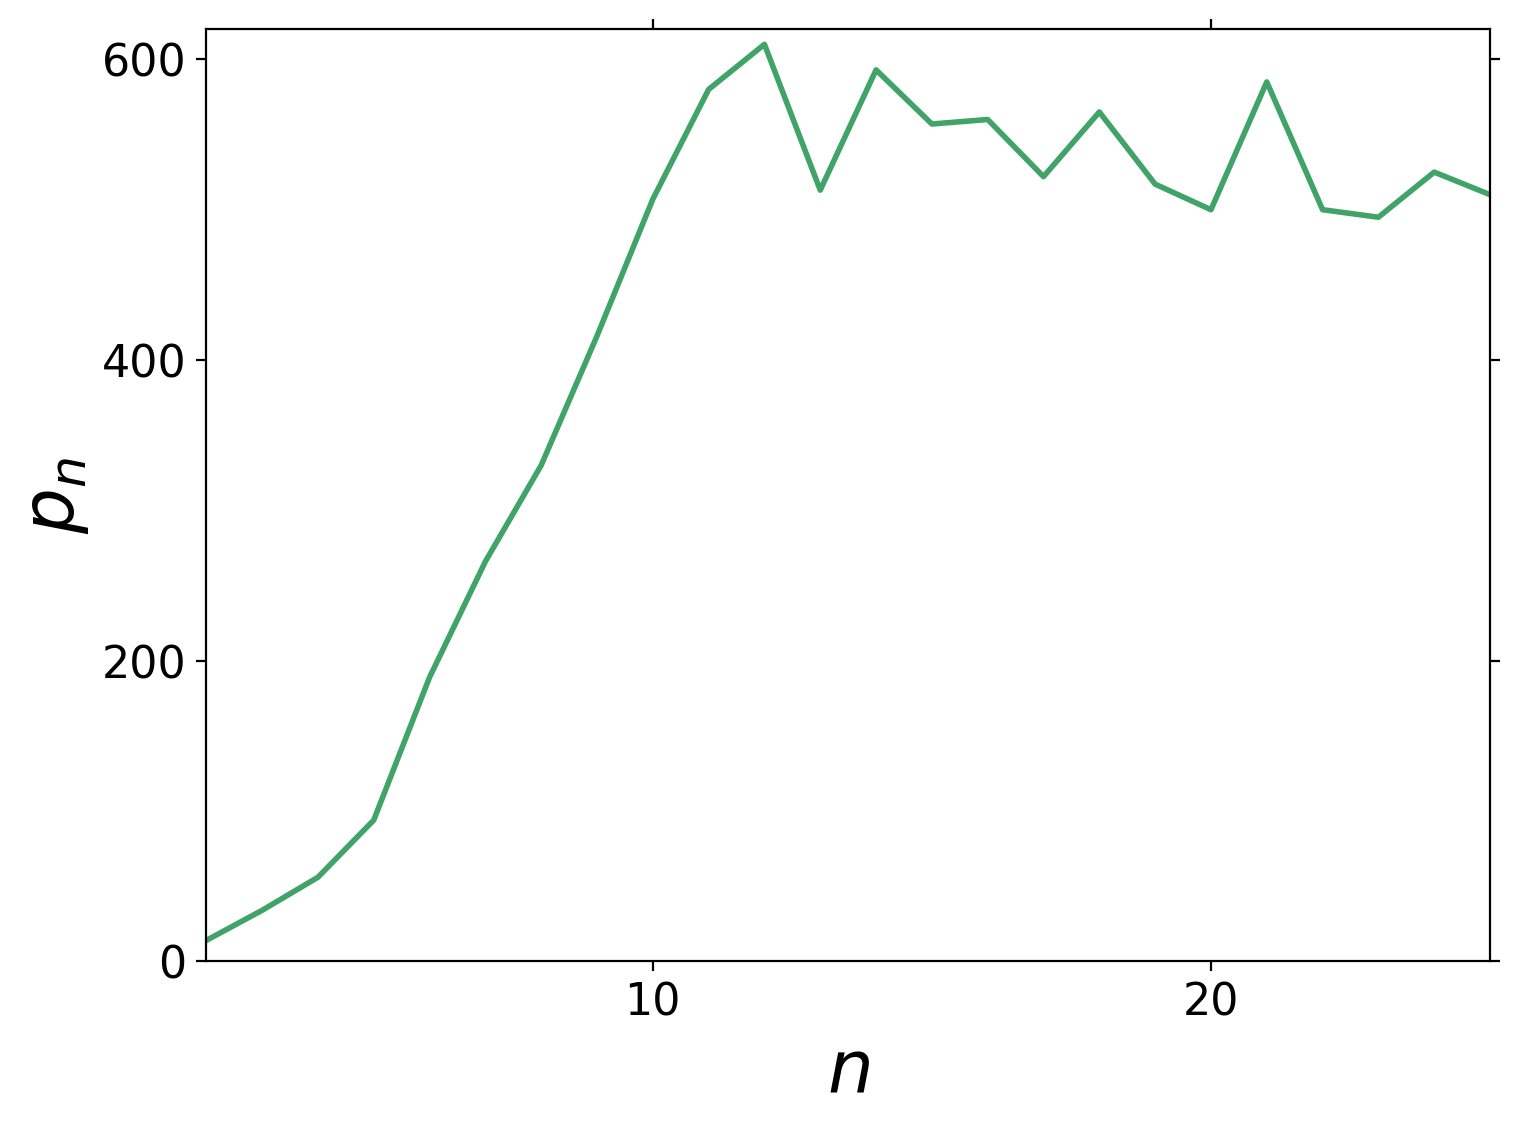

In [4]:
fig, ax =plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

data['Density'].plot(color='xkcd:greenish', linewidth=2) 

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.xlim([2, 25])
plt.ylim([0, 620])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'gause_raw_data.png'
#plt.savefig(figname, dpi=600)

plt.show()

So, the density initially grows very quickly, until about day 10 when it begins just roughly oscillating around approximately $500$. 

Our goal is to write down a mathematical function $n\mapsto p_{n}$ that approximately fits this curve. 

A quick note before proceeding: we'll have to clean the data a bit since days $0$ and $1$ don't have well-defined densities, and the change in density at the last time is not defined. 

In [5]:
dens =  data['Density'].to_numpy()
dens = dens[2:]

print("Densities = ", dens)

dens_ch = data['Change in Density'].to_numpy()
dens_ch = dens_ch[2:-1]

print("Density Changes = ", dens_ch)

Densities =  [ 14.  34.  56.  94. 189. 266. 330. 416. 507. 580. 610. 513. 593. 557.
 560. 522. 565. 517. 500. 585. 500. 495. 525. 510.]
Density Changes =  [ 20.  22.  38.  95.  77.  64.  86.  91.  73.  30. -97.  80. -36.   3.
 -38.  43. -48. -17.  85. -85.  -5.  30. -15.]


## Section 2: Malthusian Model

The first model we examine assumes that the population density simply changes by a fixed factor of $r>0$ (the **reproduction rate**) per day. In symbols, this mathematical relationship reads
$$
p_{n+1} = rp_{n}. 
$$
We call this model the **Malthusian model**, since it is related to Thomas Malthus' early work in population dynamics. 

Note how our model allows us to compute $p_{n}$ for any $n\geq 0$ knowing only $p_0$ (which we would just take from the data), by recursively applying the growth formula above. Don't underestimate the importance of this property: it is the ecological, discrete-time version of Newton's conception of dynamics (compute particle trajectories knowing only their initial states and the forces they experience)! In mathematical terms, this means we're modelling the population as a **discrete-time dynamical system** (dynamical=time-varying). More specifically, one calls our update rule a **difference equation** since it can be written as condition on the difference of the densities at successive times. 

Now, let's simulate the Malthusian model for various values of $r$ to get a feeling for what it does. 

In [6]:
def simulate_malthus(r, p0, T):
    
    p_malthus = np.zeros(T-1, dtype=float)

    p_malthus[0] = p0 # take initial state from the data

    for n in range(1,T-1):
        
        p_malthus[n] = r * p_malthus[n-1]
        
    return p_malthus

In [7]:
r = 1.17

T = 25

p_malthus = simulate_malthus(r, 14., T)

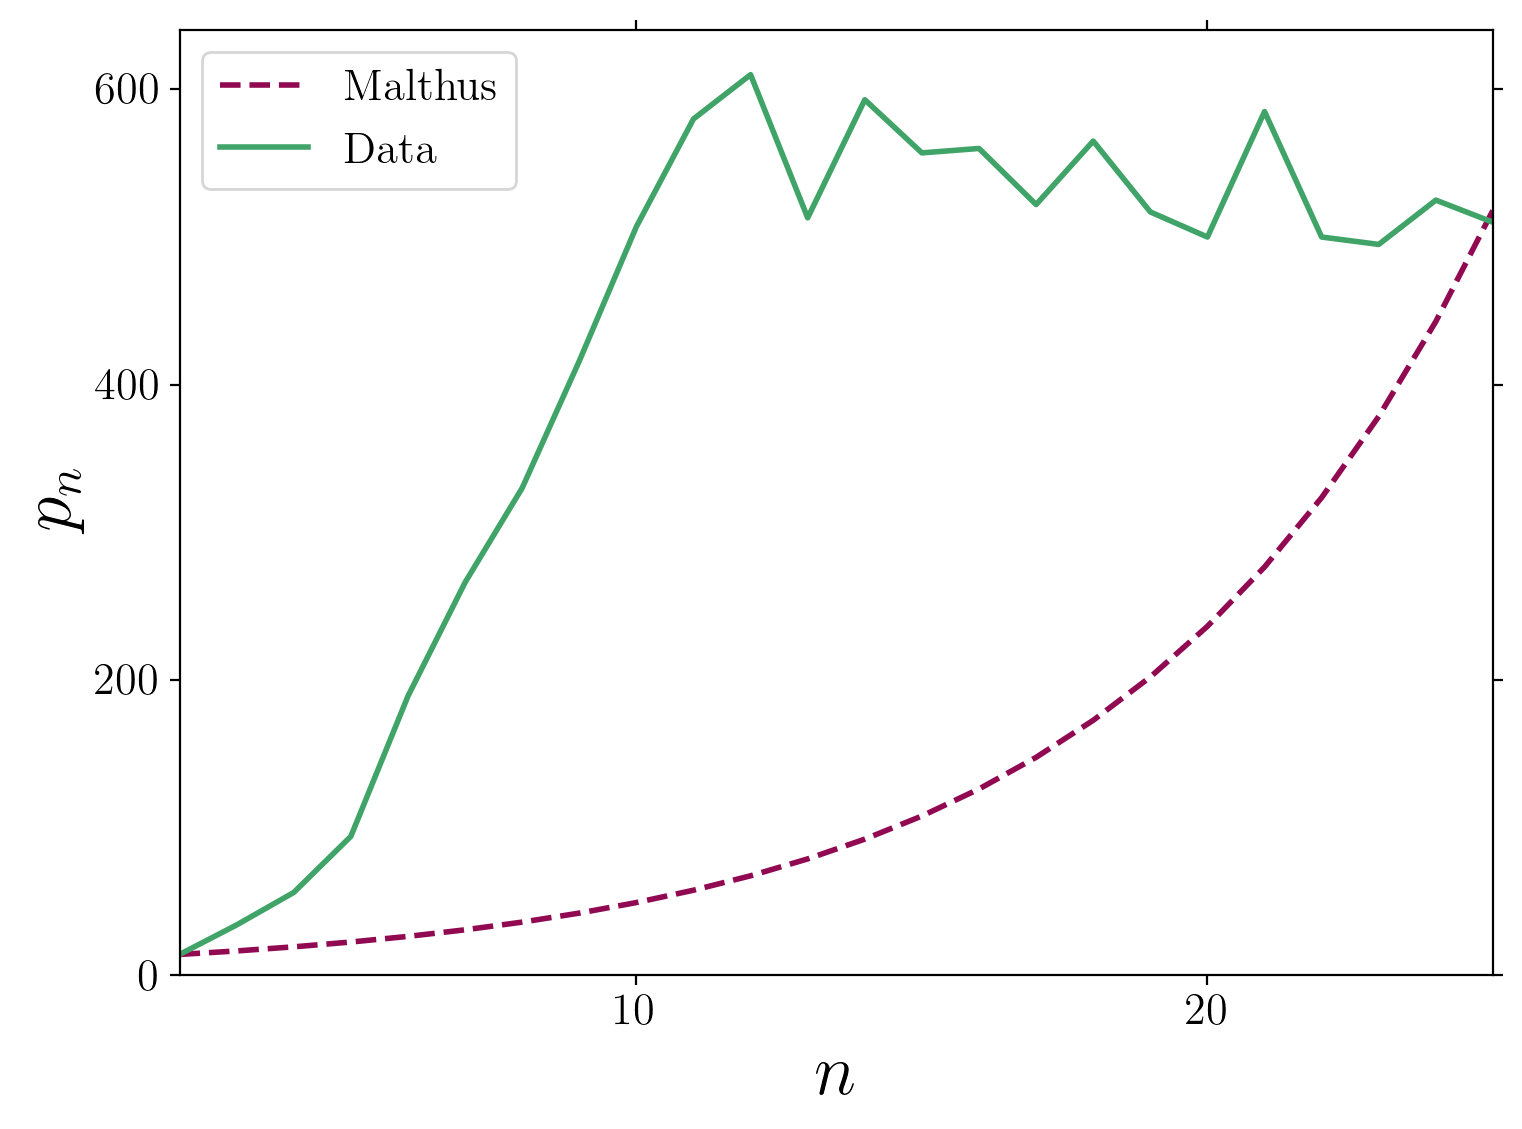

In [8]:
fig, ax =plt.subplots()   
    
plt.plot(np.arange(2,T+1), p_malthus, color='xkcd:reddish purple', linestyle='dashed', label='Malthus', linewidth=2)
plt.plot(np.arange(2,T+1), dens, color='xkcd:greenish', label='Data', linewidth=2)

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

ax.legend(fontsize=16)

plt.xlim([2, 25])
plt.ylim([0, 1.05*np.amax(dens)])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'malthus_sim.png'
#plt.savefig(figname, dpi=600)

plt.show()

So, it looks like the Malthusian model qualitatively captures the initial rapid growth in the density, but fails to capture the level-off. Why should this be "in plain English"? Well, the Malthusian model assumes the population always increases at a fixed rate. Is this biologically reasonable? Perhaps, if the supply of nutrients for the paramecia increased with the population, but it doesn't: Gause kept the level of nutrients in his population constant. So, while it is reasonable to expect fast, Malthusian growth for a short time, eventually there are so many organisms that they must start competing with one another for the fixed amount of food available. This competition will slow the growth rate down: based on our data, the growth rate should in fact tend to about zero. So, a constant growth rate must be thrown out. 

All in all, it seems that the Malthus model is a pretty bad fit for Gause's data, and common-sense scientific reasoning would lead us to expect this anyway. 

However, to be $100 \%$ sure that the Malthusian model can't be saved, we should take some time to compute the optimal value of the parameter $r$. Ok, how do we do this? The answer is to use the data at hand. 

By subtracting $p_{n}$ from both sides of the Malthusian recurrence relation, we find
$$
\Delta p_{n} = (r-1)p_{n}. 
$$
Thus, $r-1$ is simply the slope of the line of best fit on a $\Delta p_{n}$ versus $p_{n}$ graph. So, all we have to do is get that line of best fit! Though the underlying theory is a bit beyond the scope of this course, finding a line of best fit is probably one of the easiest coding tasks there is, and it can be solved a bunch of different ways. For the benefit of your Python knowledge, I'll show you two different ways using SciPy and SciKit-Learn. We'll see that both ways produce the same estimate for $r$. 

In [9]:
# For convenience when making plots later, sort data before we do regression. 
# Neither regressor cares about the sorting, but it does make our lives easier. 
# I got this solution from the discussion here:
# https://stackoverflow.com/questions/32019398/python-sorting-y-value-array-according-to-ascending-x-array

import operator
x = dens[:-1]
y = dens_ch

L = sorted(zip(x,y), key=operator.itemgetter(0))

x, y = zip(*L)

x = np.array(x)
y = np.array(y)

In [10]:
#### scipy version
from scipy.stats import linregress

sp_regression = linregress(x,y) # NOTE: have to cut off the manipulated variable!

r_best = 1. + sp_regression.slope

print('SciPy Regressor Estimate = ', r_best)

SciPy Regressor Estimate =  0.8677707025989262


In [11]:
#### sklearn version for comparison.... 
from sklearn import linear_model

sklearn_regressor = linear_model.LinearRegression()
sklearn_regressor.fit(x.reshape(23,1), y)

r_best_sklearn = 1+sklearn_regressor.coef_

print('SciKit-Learn Regressor Estimate = ', r_best_sklearn)

SciKit-Learn Regressor Estimate =  [0.8677707]


We see that there is no difference between the two different slope estimates: they both give
$$
r = 0.867707 \ . 
$$
This should activate your applied mathematician's spidey sense: if $r<1$, the Malthusian model predicts *shrinking*, not growth, at every time step! So, parameter "optimization" is producing an even worse fit! 

You may ask, then, why we have bothered with such an optimization here (or really why we've bothered with Malthus in the first place). The answer is that this model is so simple that it makes for an ideal playground in which to explain parameter fitting and modelling validation (more like invalidation!): if you master the "how" for the Malthusian model, understanding the more complicated model-testing in subsequent sections will be easy. 

Now, we plot the regressed line against the actual data. 

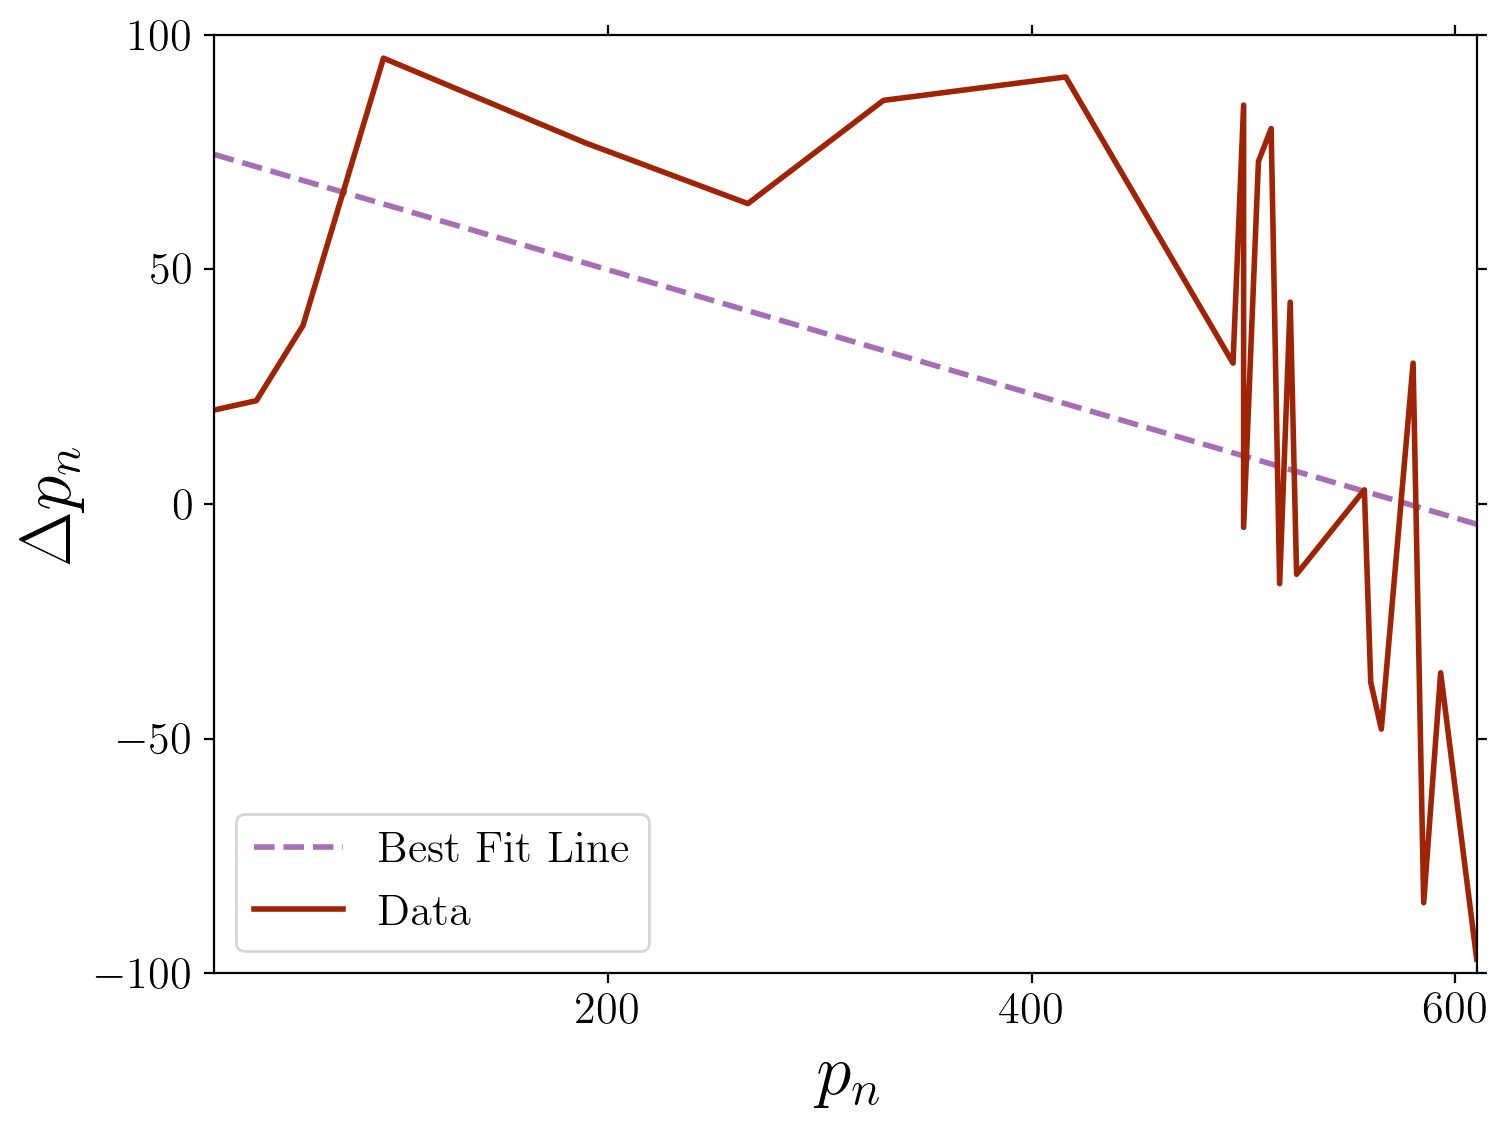

In [12]:
fig, ax = plt.subplots()   
    
plt.plot(x, sp_regression.slope*x+sp_regression.intercept, color='xkcd:soft purple', linestyle='dashed', label='Best Fit Line', linewidth=2)
plt.plot(x,y, color='xkcd:burnt red', linestyle='solid', label='Data', linewidth=2)

plt.xlabel(r"$p_{n}$", fontsize=26, color = 'k')
plt.ylabel(r"$\Delta p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

ax.legend(fontsize=16)

plt.xlim([14, 610])
plt.ylim([-100,100])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'malthus_regression.png'
#plt.savefig(figname, dpi=600)

plt.show()

Qualitatively, the fit is pretty poor, but does it at least produce a good model? We already know the answer is "no" since $r<1$, but let's simulate the Malthus model so we can really wallow in its awfulness: 

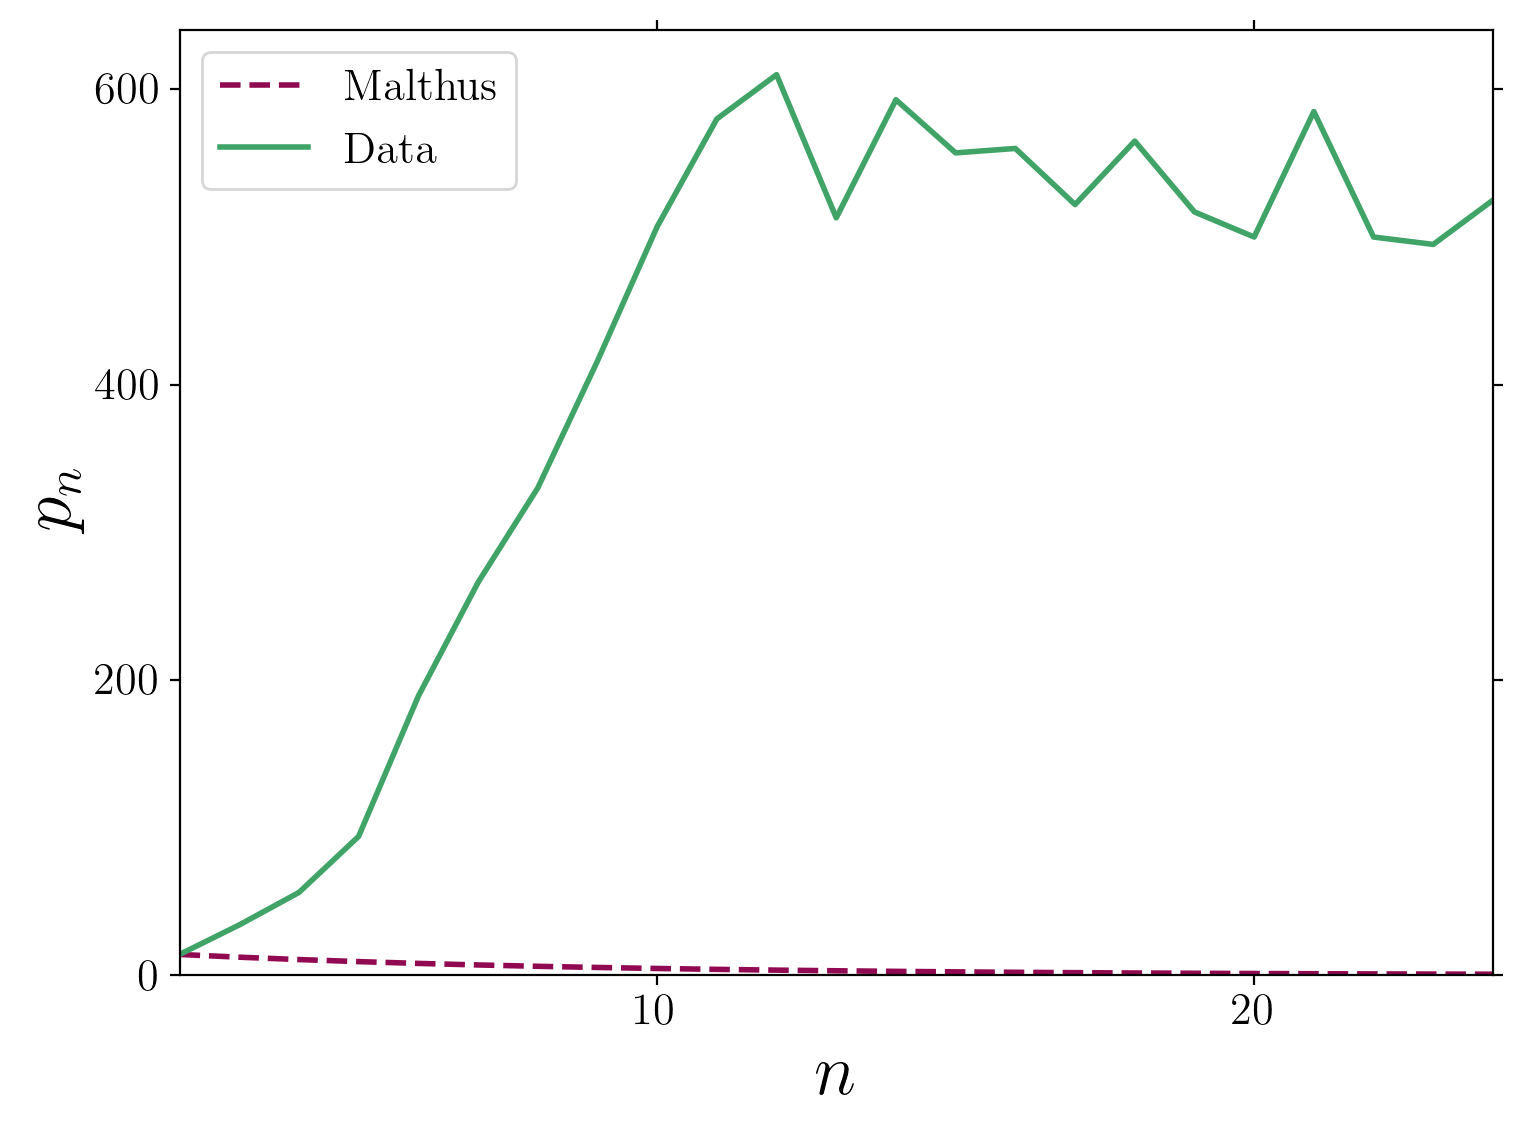

In [13]:
fig, ax =plt.subplots()   
    
p_malthus_best = simulate_malthus(r_best, 14., T-1)
plt.plot(np.arange(2,T), p_malthus_best, color='xkcd:reddish purple', linestyle='dashed', label='Malthus',linewidth=2)
plt.plot(np.arange(2,T+1), dens, color='xkcd:greenish', label='Data', linewidth=2)

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

ax.legend(fontsize=16)

plt.xlim([2, 24])
plt.ylim([0, 1.05*np.amax(dens)])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'malthus_sim_best.png'
#plt.savefig(figname, dpi=600)

plt.show()

The model really looks like garbage! So, no more Malthus for us today. 

## Section 3: Discrete Logistic Model

The big issue with the Malthusian model was that it implicitly assumed the paramecia had infinitely many resources on which to feed, and thereby sustain a constant growth rate. Of course, since the paramecia actually have a finite, constant amount of available nutrients, the growth rate needs to eventually tend to zero as the population gets large. In biology, this is called **logistic growth**. 

Let's try to model a density-dependent growth rate $r(p_n)$ that gives rise to (approximately) logistic growth. That is, we want to look for models that are discrete dynamical systems of the form 
$$
\Delta p_{n} = r(p_n).
$$

What constraints must $r(p_n)$ satisfy? Here are some ideas:  

1) First, $r(0)=0$, since organisms cannot magically appear out of nowhere. 

2) Second, $r(p_{n})$ should vanish when $p_{n}$ reaches a certain threshold density $K>0$: $r(K)=0$. This would represent the growth rate going to zero when the population gets sufficienty big. 

3) Finally, we need $r(p_n)\geq 0$ to guarantee growth.

The simplest function satisfying both constraints involves two parameters $a,K>0$: 

$$
r(p_{n}) = a(K-p_{n})p_{n}. 
$$

This leads to a model of the form 

$$
p_{n+1} = p_{n} + a(K-p_{n})p_{n},
$$

called the **discrete logistic model (DLM)**. Let's start experimenting with this model using Python. 

We use nonlinear fitting with SciPy to estimate the best parameters from $a,K$. This is like finding the *parabola* of best fit on the $\Delta p_n$ vs. $p_{n}$ data, rather than the line of best fit like we saw with Malthus. Don't worry about the "why" here, I just want to show you that Python packages can be used to perform the important scientific task of parameter estimation. 

In [14]:
from scipy.optimize import curve_fit

def parabola(x, a, K):
    return a*(K-x)*x

params_opt = curve_fit(parabola, x,y)
 
a_best = params_opt[0][0]

K_best = params_opt[0][1]

print('Optimal value of a = %.5f' % a_best)
print('Optimal value of K = %.1f' % K_best)

Optimal value of a = 0.00145
Optimal value of K = 542.2


Now, we write a function for simulating DLM up to a prescribed time $T$. 

In [15]:
def simulate_dlm(a,K,p0,T):
    
    p_dlm = np.zeros(T-1, dtype=float)

    p_dlm[0] = p0 # take initial state from the data

    for n in range(1,T-1):
        
        p_dlm[n] = p_dlm[n-1] + a * p_dlm[n-1] * (K-p_dlm[n-1])
        
    return p_dlm

We simulate DLM with the optimal parameters and plot the results and Gause's data on the same axes. 

In [16]:
p_dlm_best = simulate_dlm(a_best, K_best,14., T-1)


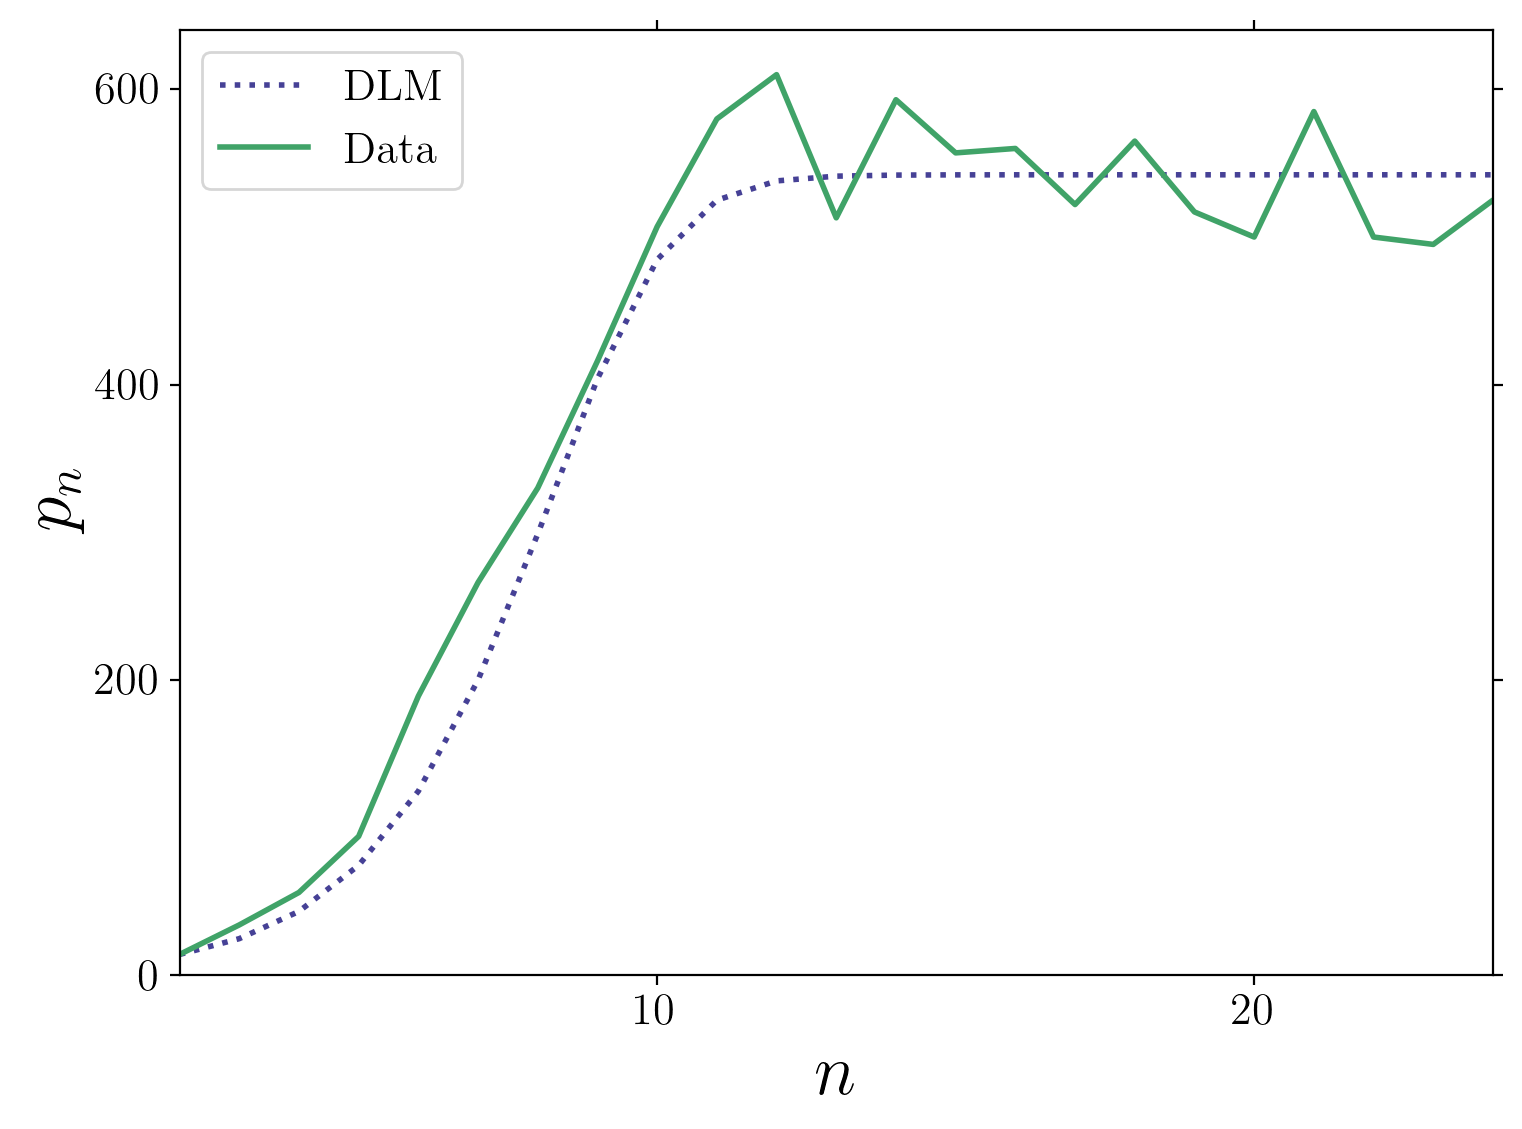

In [17]:
fig, ax =plt.subplots()   

plt.plot(np.arange(2,T), p_dlm_best, color='xkcd:blueberry', linestyle='dotted', label='DLM', linewidth=2)
plt.plot(np.arange(2,T+1), dens, color='xkcd:greenish', linestyle='solid', label='Data', linewidth=2)

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

ax.legend(fontsize=16)

plt.xlim([2, 24])
plt.ylim([0, 1.05*np.amax(dens)])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'dlm_sim_best.png'
#plt.savefig(figname, dpi=600)

plt.show()

Wow! This fit looks pretty good. So, even a simple method that accounts for finite nutrients vastly improves model quality. 

We've can also print the mean-square error in our model to attach a number to this picture: 

In [18]:
# compute error 
RMSE_dlm = np.linalg.norm(p_dlm_best-x)

print('RMSE for DLM = ', RMSE_dlm)

RMSE for DLM =  165.23634031270007


Now comes the bad news. Despite the DLM providing an excellent fit, it has some features that make it a less-than-desirable model. For instance, depending on the values of $a, K$, it can actually exhibit **chaotic** behaviour, which for now we'll understand to simply mean non-periodic "oscillations". Here is an example of a chaotic trajectory for DLM: 

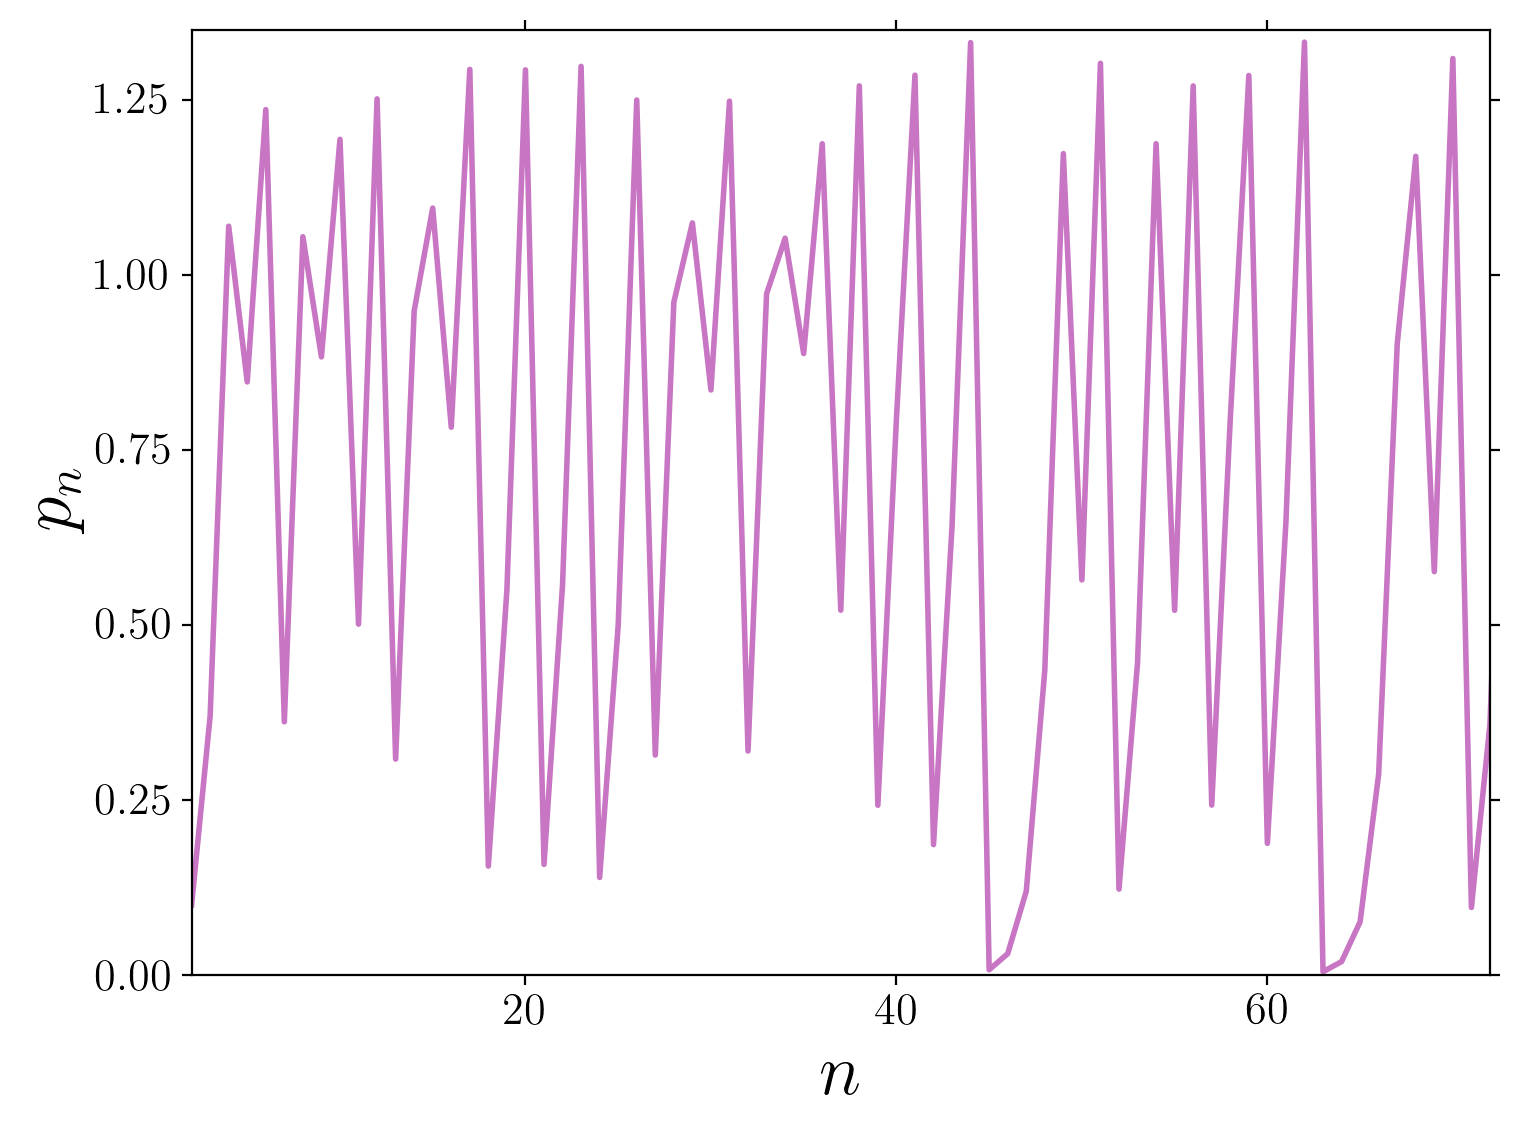

In [19]:
fig, ax =plt.subplots()   

p_dlm_chaotic = simulate_dlm(3,1, 0.1, 3*T-1)
plt.plot(np.arange(2,3*T), p_dlm_chaotic, linestyle='solid', color='xkcd:orchid', linewidth=2)

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

plt.xlim([2, 72])
plt.ylim([0, 1.35])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'dlm_chaos.png'
#plt.savefig(figname, dpi=600)

plt.show()

I encourage you to play around more with the parameters of DLM and encounter other types of solutions (other chaotic solutions, true oscillations, and more!).

Chaotic oscillations are definitely not reasonable in this modelling context, so we should try to avoid any models that run the risk of encountering chaos. You may (very reasonably) say that the optimal parameters we found from the data do not lead to chaos in DLM, so there's no reason to be worried. I would respond by saying that the best models harmonize data and mathematical structure, so just because we have a good fit we shouldn't rest on our laurels and ignore a pretty significant mathematical issue. 

Perhaps more pragmatically, it could happen that different population growth experiments with different organisms would give rise to chaotic parameters for DLM, in which case DLM working for Gause's data would simply be a "happy accident". 

You may ask how one could predict chaos without just messing around with the above code for an afternoon. Part of the answer involves **stability analysis** and **bifurcation theory**, which are tools for understanding the sensitivity of dynamical systems to both initial states and parameters. Digging into these topics requires a background in calculus (the science of sensitivity to small changes!), and I encourage you to come back to this material once you obtain such background. 

## Section 3: Beverton-Holt Model

Now, we present a third model, the **Beverton-Holt model (BH)** that has all the best parts of DLM, but avoids the nasty chaos. We'll simply write the model down for now (the "natural" derivation will be covered later on in our course) and verify that is satisfies the same three constraints that we placed on DLM. 

In terms of two parameters $b, L$, the dynamical update rule for BH reads 

$$
p_{n+1} = \frac{b}{1+\frac{b-1}{L}p_{n}} p_{n}. 
$$

which can be re-arranged to yield

$$
\Delta p_{n} = p_{n} \left( \frac{b}{1+\frac{b-1}{L}p_{n}} -1 \right),
$$

the form of the update rule we use for parameter estimation via nonlinear regression. 

1) First, we immediately verify that the growth rate is zero when $p_{n}=0$. 

2) Second, a bit of algebra shows that the growth rate also vanishes if $p_{n}=L$. So, the growth rate also has a root at some positive threshold value. 

3) Guaranteeing a positive growth rate is a little tougher because the parameters are so complicated, so we won't check this until we actually perform simulations

First, let's find the optimal parameters $b,L$ with nonlinear fitting, as we did with DLM. 

In [20]:
def bh_curve(x, b, L):
    return x*(-1. + b*L/(L+(b-1.)*x))

bh_params_opt = curve_fit(bh_curve, x, y, p0=[1., K_best], bounds= [[1, 0], [np.inf, np.inf]])
# for some reason the optimizer has a tough time with the BH curve, probably because it has 
# issues around L=0. So, you have to put bounds in to get a reasonable result! 
    
b_best = bh_params_opt[0][0]

L_best = bh_params_opt[0][1]

print('Optimal value of b = %.5f' % b_best)
print('Optimal value of L = %.1f' % L_best)

Optimal value of b = 2.15564
Optimal value of L = 541.3


Now, we create a function for simulating BH. 

In [21]:
def simulate_bh(b,L,p0,T):
    
    p_bh = np.zeros(T-1, dtype=float)

    p_bh[0] = p0 # take initial state from the data

    for n in range(1,T-1):
        
        p_bh[n] = p_bh[n-1]*(b*L)/(L+(b-1)*p_bh[n-1])
        
    return p_bh

We simulate BH with the optimal parameters and compare it against the raw data. 

In [22]:
p_bh_best = simulate_bh(b_best, L_best ,14., T-1)

RMSE_bh = np.linalg.norm(p_bh_best-x)

print('RMSE for BH = ', RMSE_bh)

RMSE for BH =  154.6209127985637


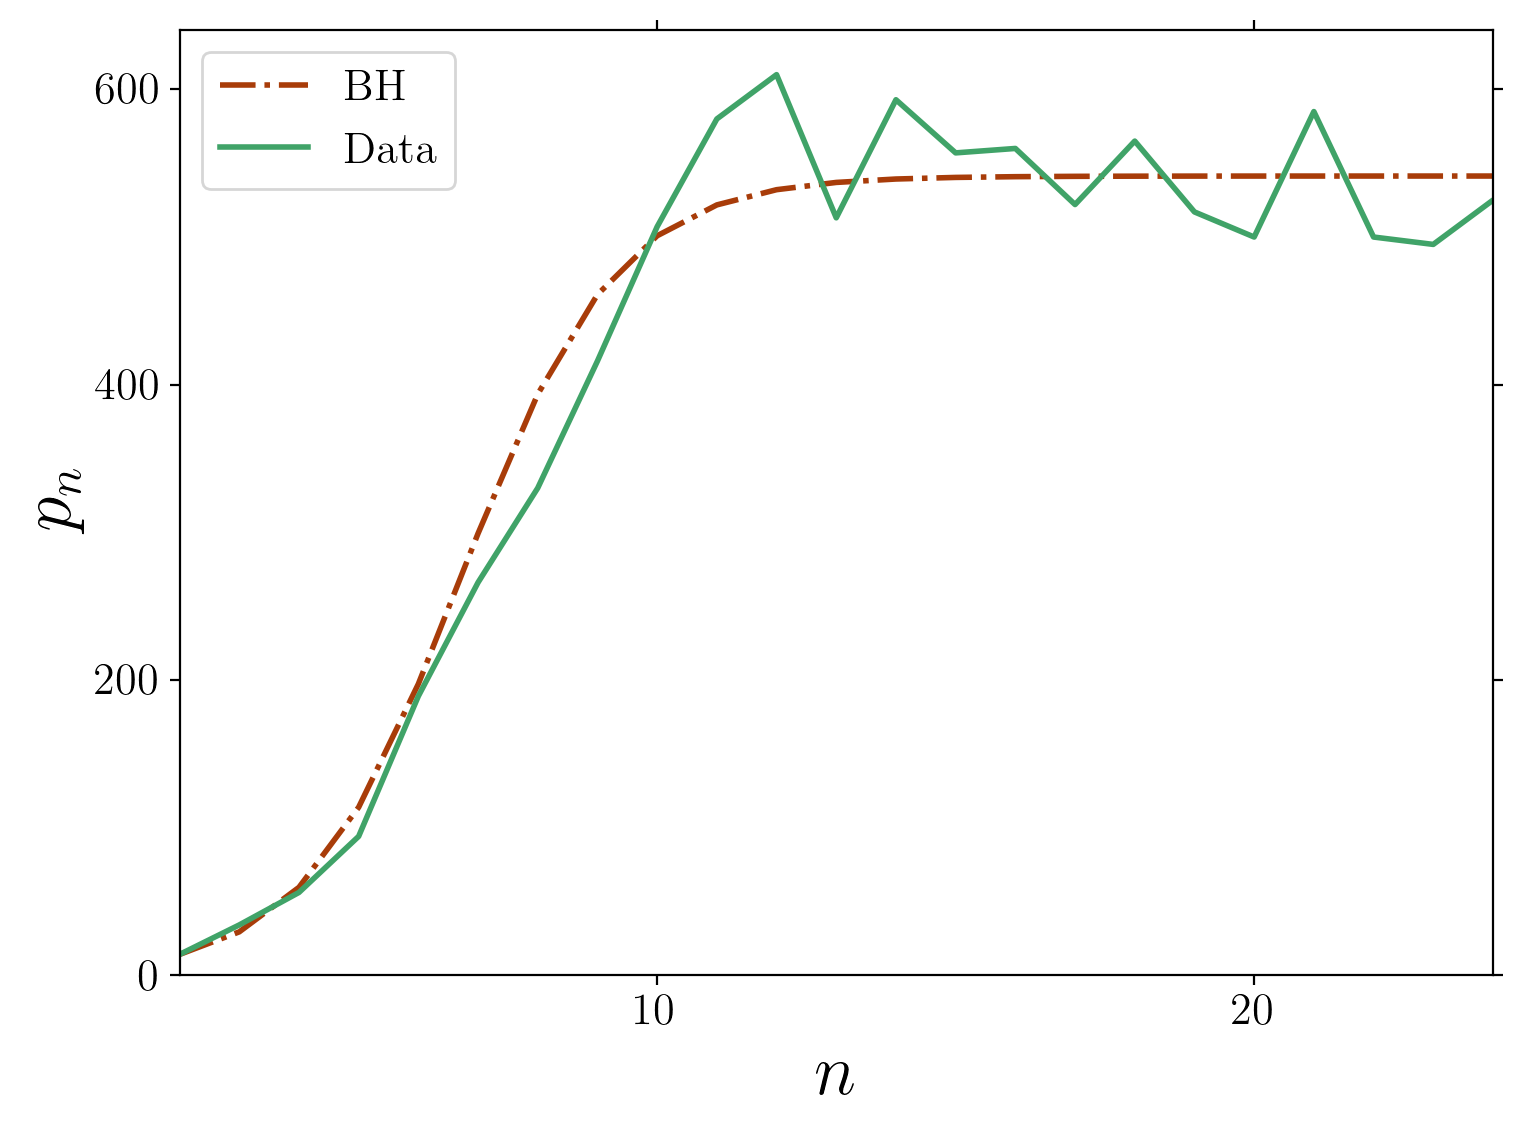

In [24]:
fig, ax =plt.subplots()   

plt.plot(np.arange(2,T), p_bh_best, linestyle='dashdot', color='xkcd:rust', label='BH', linewidth=2)
plt.plot(np.arange(2,T+1), dens, color='xkcd:greenish', linestyle='solid', label='Data', linewidth=2)

plt.xlabel(r"$n$", fontsize=26, color = 'k')
plt.ylabel(r"$p_{n}$", fontsize=26, color='k')

plt.tick_params(axis='x', which='both', top='off', color = 'k')
plt.xticks(fontsize=16, rotation=0, color = 'k')
plt.tick_params(axis='y', which='both', right='off', color = 'k')
plt.yticks(fontsize=16, rotation=0, color = 'k')
ax.locator_params(axis='y', nbins=6)
ax.locator_params(axis='x', nbins=4)

ax.legend(fontsize=16)

plt.xlim([2, 24])
plt.ylim([0, 1.05*np.amax(dens)])

plt.tight_layout()

fig.set_size_inches(8, 6)  
        
#figname = 'bh_sim_best.png'
#plt.savefig(figname, dpi=600)

plt.show()

BH produces a population curve that roughly fits the data nicely. The RMSE is also slightly smaller for BH than DLM, their relative difference being about 7% better. So, on "raw numbers" alone, BH barely wins. 

Additionally, while DLM may have chaotic solutions, BH has the following desirable property: 

**Theorem**: As $n\rightarrow \infty$, solutions of BH with $p_0>0$ always tend to

$$
p_{\text{eq}} = \frac{bL}{b-1}. 
$$

That is, $p_{\text{eq}}$ is a **stable equilibrium**. 

*Sketch of Proof*

Theorems of this sort are usually proven with stability and bifurcation analysis and other tools from dynamical systems theory. However, for BH, the proof is very easy: one simply verifies via the substitution $p_{n}\mapsto u_{n} = p_{n}^{-1}$ that the exact solution for $p_{n}$ (evolving according to BH) is 

$$
p_{n} = \frac{b^{n}}{1+\frac{b^{n}-1}{L}p_0}p_{0}. 
$$

You can check this yourself if you know how to solve linear difference equations (for an intro to this topic, see https://people.math.umass.edu/~lr7q/ps_files/teaching/math456/Chapter3.pdf). 

Having an exact solution for a dynamical system is very rare, so don't count on it in general! With this solution in hand, we simply compute the limit assuming $p_0\neq 0$:

\begin{align*}
\lim_{n\rightarrow \infty} p_{n} &= bL \lim_{n\rightarrow \infty} \frac{b^{n-1}}{(b^{n}-1)+\frac{L}{p_0}}
\\ \\ 
&= bL \lim_{n\rightarrow \infty} \frac{b^{n-1}}{(b-1)(b^{n-1} + b^{n-2}+\cdots+b+1)+\frac{L}{p_0}}
\\ \\ 
&= p_{\text{eq}} \lim_{n\rightarrow \infty} \frac{b^{n-1}}{(b^{n-1} + b^{n-2}+\cdots+b+1)+\frac{L}{p_0(b-1)}}
\\ \\ 
&= p_{\text{eq}},
\end{align*}
so we're all done. 


This means that Beverton-Holt indeed describes logistic growth: it fits the data and is backed up by solid mathematics. So, out of the three dynamical models considered today, Beverton-Holt seems to give the best overall model for Gause's laboratory observations. 